# Installing and Importing and Initializing Libraries.

In [ ]:
import numpy as np 
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
pd.set_option('display.max_row', 500)
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', None)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Defining utility functions for Data Engineering process

In [1]:
def window(df, win_size):
    ind=df.index[df['event'].isna()==False]
    c=0
    df['window']=np.nan
    for i in tqdm(ind):
        a=i-win_size
        b=i+win_size
        df['window'].loc[a:i]=int(c)
        c=c+1
        df['window'].loc[i:b]=int(c)
        c=c+1
    df['window'].dropna(inplace=True)
    return df[df['window'].isna()==False]
def inactive_periods(df):
    print("shape before application: ",df.shape)
    df['diff_anglez']=df['anglez'].diff()
    df=df[(df['enmo']!=0.0) | (df['diff_anglez']!=0.0)]
    print("shape after application: ",df.shape)
    df.drop('diff_anglez', inplace=True, axis=1)
    print("shape after completion: ",df.shape)
    print("removed ")
    return df

def clustering(df):
    from sklearn.cluster import KMeans
    from sklearn.preprocessing import StandardScaler    
    X=df[['anglez','enmo']]
#Scalling the data
    scaler=StandardScaler()
    X_scaled=scaler.fit_transform(X)
#perform clustering
    model=KMeans(n_clusters=4,algorithm="elkan" )
    model.fit(X_scaled)
    return model.labels_

 def rollingstd(series_df):
    series_df['sd_enmo_1']=np.nan    
    series_df['sd_anglez_1']=np.nan  
    series_df['m_enmo_2']=np.nan     
    series_df['m_anglez_2']=np.nan   
    print('anglez rolling std 12')
    series_df['sd_anglez_1'] = (series_df.groupby('series_id')['anglez']
                      .rolling(12)
                      .std()
                      .reset_index(level=0, drop=True))
    print('anglez rolling std 2')
    series_df['sd_anglez_1'][series_df['sd_anglez_1'].isna()==True] = (series_df.groupby('series_id')['anglez']
                      .rolling(2)
                      .std()
                      .reset_index(level=0, drop=True))
    print('enmo rolling std 12')
    series_df['sd_enmo_1'] = (series_df.groupby('series_id')['enmo']
                      .rolling(12)
                      .std()
                      .reset_index(level=0, drop=True))
    print('enmo rolling mean 24')
    series_df['m_enmo_2'] = (series_df.groupby('series_id')['enmo']
                      .rolling(24)
                      .mean()
                      .reset_index(level=0, drop=True))
    print('anglez rolling mean 24')
    series_df['m_anglez_2'] = (series_df.groupby('series_id')['anglez']
                      .rolling(24)
                      .mean()
                      .reset_index(level=0, drop=True))
    print('enmo rolling std 2')
    print('Nans in sd_emno_1: ',series_df['sd_enmo_1'].isnull().sum())
    series_df['sd_enmo_1'][series_df['sd_enmo_1'].isna()==True] = (series_df.groupby('series_id')['enmo']
                      .rolling(2)
                      .std()
                      .reset_index(level=0, drop=True))
    print('enmo rolling mean 2')
    series_df['m_enmo_2'][series_df['m_enmo_2'].isna()==True] = (series_df.groupby('series_id')['enmo']
                      .rolling(2)
                      .mean()
                      .reset_index(level=0, drop=True))
    print('anglez rolling mean 2')
    series_df['m_anglez_2'][series_df['m_anglez_2'].isna()==True] = (series_df.groupby('series_id')['anglez']
                      .rolling(2)
                      .mean()
                      .reset_index(level=0, drop=True))
    
    print('Nans in sd_emno_1: ',series_df['sd_enmo_1'].isnull().sum())
    series_df['sd_enmo_1'].fillna(0.0, inplace=True)
    series_df['sd_anglez_1'].fillna(0.0, inplace=True)
    series_df['m_enmo_2'].fillna(0.0, inplace=True)
    series_df['m_anglez_2'].fillna(0.0, inplace=True)
    print('Nans after removal: ',series_df['sd_enmo_1'].isnull().sum())

    return(series_df)

def scale(X):
    from sklearn import preprocessing
    scaler=preprocessing.StandardScaler().fit(X)
    return (scaler.transform(X))


# Creating Training Data

In [1]:
# Importing the datasets
print('Importing Training Datasets')
df_series=pd.read_parquet(path="/kaggle/input/child-mind-institute-detect-sleep-states/train_series.parquet", engine='auto')
df_events=pd.read_csv("/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv")
print('Dataset Imported...')
# Removing the periods of inactivity
print('Removing the periods of Inactivity...')

Importing Training Datasets


NameError: name 'pd' is not defined

In [ ]:
print('Merging the training datasets...')
events=df_events[['series_id', 'step','event']]
series_df=pd.merge(df_series,events,on=["step","series_id"],how='left')
df_series=[]
df_event=[]
series_df['sleep']=np.nan
series_df.loc[series_df["event"]=="onset", "sleep"] = 1
series_df.loc[series_df["event"]=="wakeup", "sleep"] = 0
series_df['sleep'].fillna(method='ffill', inplace=True)
series_df['sleep'].fillna(value=0, inplace=True)
print('Datasets Merged...')

series_df=inactive_periods(series_df)
print('______________________________________')

win_size=720  #60mins
print('Creating Windows each size: ',win_size)
series_df=window(series_df,win_size)
print('Windows formed...')

print('Adding columns to account for deviation in enmo and anglez 1 min rolling...')
series_df=rollingstd(series_df)
series_df['sd_anglez_1']=pd.to_numeric(series_df['sd_anglez_1'])
series_df['sd_enmo_1']=pd.to_numeric(series_df['sd_enmo_1'])
series_df['m_anglez_2']=pd.to_numeric(series_df['m_anglez_2'])
series_df['m_enmo_2']=pd.to_numeric(series_df['m_enmo_2'])

print('Clustering the data based on enmo and anglez...')
series_df['cluster']=(clustering(series_df)+1)/4

X=series_df[['sd_anglez_1','sd_enmo_1','anglez','m_anglez_2','m_enmo_2','enmo','cluster']]
y=series_df[['sleep']]
X=scale(X)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

def make_classification(clf):
    clf.fit(X_train, y_train)
    preds = clf.predict(X_val)
    name = str(model.__class__).split(".")[-1][:-2] + ": "
    print(name + "report")
    print(classification_report(y_val, preds)), 
    print(name + str(f1_score(y_val, preds)))
    return 

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
print("Shape:", X_train.shape, X_val.shape, y_train.shape, y_val.shape)

In [16]:
%%time


DT = DecisionTreeClassifier()

gbc = GradientBoostingClassifier(n_estimators=30, min_samples_leaf=10, random_state=42, verbose=True)
abc = AdaBoostClassifier(n_estimators=10)
svc = SVC()

ensemble_clf = StackingClassifier(
    estimators=[ ("ABC", AdaBoostClassifier()), ("Gradient Boost", gbc), ("NB", GaussianNB()), ("LR", LogisticRegression())],
    final_estimator= DecisionTreeClassifier(max_depth=5, random_state=42),  # You can choose another classifier as the final estimator
    verbose=True
)


make_classification(ensemble_clf, StandardScaler())

# clf = make_pipeline(StandardScaler(), ensemble_clf)
# clf.fit(X_train, y_train)

# print("Ensemble training accuracy: ", clf.score(X_train, y_train))
# print("Ensemble valid accuracy: ", clf.score(X_val , y_val))

      Iter       Train Loss   Remaining Time 
         1           1.2667           13.08m
         2           1.1813           12.60m
         3           1.1107           12.15m
         4           1.0518           11.75m
         5           1.0024           11.31m
         6           0.9603           10.86m
         7           0.9246           10.40m
         8           0.8943            9.93m
         9           0.8681            9.48m
        10           0.8455            9.03m
        20           0.7361            4.50m
        30           0.7075            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.2667           11.04m
         2           1.1815           10.63m
         3           1.1109           10.22m
         4           1.0520            9.84m
         5           1.0026            9.47m
         6           0.9606            9.10m
         7           0.9250            8.72m
         8           0.8945            8.34m
        

In [ ]:
dt_classifier = DecisionTreeClassifier()

# Define the hyperparameter grid to search
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, scoring='accuracy', cv=5)


grid_search = make_classification(grid_search)
# Get the best parameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
best_dt_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_dt_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on Test Set: {accuracy:.4f}")

Training model on cpu


Epochs:   2%|▏         | 1/50 [02:55<2:22:57, 175.05s/it]

Epoch [1/50], Training Loss: 0.6097, Validation Loss: 0.5445, Validation Accuracy: 0.7800


Epochs:   4%|▍         | 2/50 [05:31<2:11:06, 163.88s/it]

Epoch [2/50], Training Loss: 0.5239, Validation Loss: 0.5051, Validation Accuracy: 0.8099


Epochs:   6%|▌         | 3/50 [08:10<2:06:47, 161.86s/it]

Epoch [3/50], Training Loss: 0.4975, Validation Loss: 0.4893, Validation Accuracy: 0.8253


Epochs:   8%|▊         | 4/50 [10:46<2:02:11, 159.39s/it]

Epoch [4/50], Training Loss: 0.4848, Validation Loss: 0.4798, Validation Accuracy: 0.8365


Epochs:  10%|█         | 5/50 [13:32<2:01:32, 162.06s/it]

Epoch [5/50], Training Loss: 0.4770, Validation Loss: 0.4741, Validation Accuracy: 0.8397


Epochs:  12%|█▏        | 6/50 [16:09<1:57:26, 160.15s/it]

Epoch [6/50], Training Loss: 0.4724, Validation Loss: 0.4704, Validation Accuracy: 0.8432


Epochs:  14%|█▍        | 7/50 [18:48<1:54:33, 159.85s/it]

Epoch [7/50], Training Loss: 0.4691, Validation Loss: 0.4677, Validation Accuracy: 0.8458


Epochs:  16%|█▌        | 8/50 [21:27<1:51:44, 159.62s/it]

Epoch [8/50], Training Loss: 0.4667, Validation Loss: 0.4656, Validation Accuracy: 0.8478


Epochs:  18%|█▊        | 9/50 [24:08<1:49:16, 159.92s/it]

Epoch [9/50], Training Loss: 0.4648, Validation Loss: 0.4639, Validation Accuracy: 0.8489


Epochs:  20%|██        | 10/50 [26:49<1:46:50, 160.26s/it]

Epoch [10/50], Training Loss: 0.4632, Validation Loss: 0.4625, Validation Accuracy: 0.8501


Epochs:  22%|██▏       | 11/50 [29:30<1:44:19, 160.50s/it]

Epoch [11/50], Training Loss: 0.4619, Validation Loss: 0.4614, Validation Accuracy: 0.8512


Epochs:  24%|██▍       | 12/50 [32:11<1:41:44, 160.63s/it]

Epoch [12/50], Training Loss: 0.4609, Validation Loss: 0.4605, Validation Accuracy: 0.8520


Epochs:  26%|██▌       | 13/50 [34:49<1:38:34, 159.85s/it]

Epoch [13/50], Training Loss: 0.4601, Validation Loss: 0.4598, Validation Accuracy: 0.8527


Epochs:  28%|██▊       | 14/50 [37:27<1:35:31, 159.20s/it]

Epoch [14/50], Training Loss: 0.4594, Validation Loss: 0.4591, Validation Accuracy: 0.8531


Epochs:  30%|███       | 15/50 [40:05<1:32:44, 158.97s/it]

Epoch [15/50], Training Loss: 0.4588, Validation Loss: 0.4586, Validation Accuracy: 0.8535


Epochs:  32%|███▏      | 16/50 [42:43<1:29:50, 158.56s/it]

Epoch [16/50], Training Loss: 0.4583, Validation Loss: 0.4581, Validation Accuracy: 0.8539


Epochs:  34%|███▍      | 17/50 [45:19<1:26:51, 157.91s/it]

Epoch [17/50], Training Loss: 0.4579, Validation Loss: 0.4577, Validation Accuracy: 0.8541


Epochs:  36%|███▌      | 18/50 [47:56<1:24:03, 157.62s/it]

Epoch [18/50], Training Loss: 0.4575, Validation Loss: 0.4574, Validation Accuracy: 0.8543


Epochs:  38%|███▊      | 19/50 [50:34<1:21:31, 157.80s/it]

Epoch [19/50], Training Loss: 0.4571, Validation Loss: 0.4571, Validation Accuracy: 0.8544


Epochs:  40%|████      | 20/50 [53:14<1:19:16, 158.54s/it]

Epoch [20/50], Training Loss: 0.4569, Validation Loss: 0.4568, Validation Accuracy: 0.8547


Epochs:  42%|████▏     | 21/50 [55:54<1:16:49, 158.93s/it]

Epoch [21/50], Training Loss: 0.4566, Validation Loss: 0.4566, Validation Accuracy: 0.8548


Epochs:  44%|████▍     | 22/50 [58:40<1:15:09, 161.05s/it]

Epoch [22/50], Training Loss: 0.4564, Validation Loss: 0.4564, Validation Accuracy: 0.8550


Epochs:  46%|████▌     | 23/50 [1:01:21<1:12:28, 161.06s/it]

Epoch [23/50], Training Loss: 0.4562, Validation Loss: 0.4562, Validation Accuracy: 0.8551


Epochs:  48%|████▊     | 24/50 [1:04:01<1:09:34, 160.56s/it]

Epoch [24/50], Training Loss: 0.4561, Validation Loss: 0.4561, Validation Accuracy: 0.8552


Epochs:  50%|█████     | 25/50 [1:06:42<1:07:01, 160.87s/it]

Epoch [25/50], Training Loss: 0.4559, Validation Loss: 0.4560, Validation Accuracy: 0.8553


Epochs:  52%|█████▏    | 26/50 [1:09:21<1:04:01, 160.06s/it]

Epoch [26/50], Training Loss: 0.4558, Validation Loss: 0.4558, Validation Accuracy: 0.8555


Epochs:  54%|█████▍    | 27/50 [1:12:01<1:01:21, 160.08s/it]

Epoch [27/50], Training Loss: 0.4557, Validation Loss: 0.4557, Validation Accuracy: 0.8557


Epochs:  56%|█████▌    | 28/50 [1:14:40<58:36, 159.84s/it]  

Epoch [28/50], Training Loss: 0.4556, Validation Loss: 0.4556, Validation Accuracy: 0.8558


Epochs:  58%|█████▊    | 29/50 [1:17:19<55:51, 159.60s/it]

Epoch [29/50], Training Loss: 0.4555, Validation Loss: 0.4556, Validation Accuracy: 0.8558


Epochs:  60%|██████    | 30/50 [1:19:57<53:04, 159.24s/it]

Epoch [30/50], Training Loss: 0.4554, Validation Loss: 0.4555, Validation Accuracy: 0.8559


Epochs:  62%|██████▏   | 31/50 [1:22:38<50:33, 159.67s/it]

Epoch [31/50], Training Loss: 0.4553, Validation Loss: 0.4554, Validation Accuracy: 0.8560


Epochs:  64%|██████▍   | 32/50 [1:25:20<48:06, 160.37s/it]

Epoch [32/50], Training Loss: 0.4553, Validation Loss: 0.4554, Validation Accuracy: 0.8560


Epochs:  66%|██████▌   | 33/50 [1:28:00<45:22, 160.15s/it]

Epoch [33/50], Training Loss: 0.4552, Validation Loss: 0.4553, Validation Accuracy: 0.8560


Epochs:  68%|██████▊   | 34/50 [1:30:48<43:19, 162.48s/it]

Epoch [34/50], Training Loss: 0.4552, Validation Loss: 0.4553, Validation Accuracy: 0.8561


Epochs:  70%|███████   | 35/50 [1:33:31<40:41, 162.79s/it]

Epoch [35/50], Training Loss: 0.4551, Validation Loss: 0.4552, Validation Accuracy: 0.8561


Epochs:  72%|███████▏  | 36/50 [1:36:18<38:15, 163.94s/it]

Epoch [36/50], Training Loss: 0.4551, Validation Loss: 0.4552, Validation Accuracy: 0.8562


Epochs:  74%|███████▍  | 37/50 [1:39:01<35:29, 163.77s/it]

Epoch [37/50], Training Loss: 0.4551, Validation Loss: 0.4552, Validation Accuracy: 0.8562


Epochs:  76%|███████▌  | 38/50 [1:41:45<32:47, 163.94s/it]

Epoch [38/50], Training Loss: 0.4550, Validation Loss: 0.4551, Validation Accuracy: 0.8562


Epochs:  78%|███████▊  | 39/50 [1:44:32<30:11, 164.64s/it]

Epoch [39/50], Training Loss: 0.4550, Validation Loss: 0.4551, Validation Accuracy: 0.8562


Epochs:  80%|████████  | 40/50 [1:47:22<27:44, 166.43s/it]

Epoch [40/50], Training Loss: 0.4550, Validation Loss: 0.4551, Validation Accuracy: 0.8562


Epochs:  82%|████████▏ | 41/50 [1:50:15<25:15, 168.36s/it]

Epoch [41/50], Training Loss: 0.4550, Validation Loss: 0.4551, Validation Accuracy: 0.8563


Epochs:  84%|████████▍ | 42/50 [1:53:05<22:31, 168.92s/it]

Epoch [42/50], Training Loss: 0.4549, Validation Loss: 0.4551, Validation Accuracy: 0.8563


Epochs:  86%|████████▌ | 43/50 [1:55:51<19:35, 167.92s/it]

Epoch [43/50], Training Loss: 0.4549, Validation Loss: 0.4550, Validation Accuracy: 0.8563


Epochs:  88%|████████▊ | 44/50 [1:58:38<16:45, 167.64s/it]

Epoch [44/50], Training Loss: 0.4549, Validation Loss: 0.4550, Validation Accuracy: 0.8563


Epochs:  90%|█████████ | 45/50 [2:01:27<13:59, 167.94s/it]

Epoch [45/50], Training Loss: 0.4549, Validation Loss: 0.4550, Validation Accuracy: 0.8563


Epochs:  92%|█████████▏| 46/50 [2:04:14<11:11, 167.82s/it]

Epoch [46/50], Training Loss: 0.4549, Validation Loss: 0.4550, Validation Accuracy: 0.8563


Epochs:  94%|█████████▍| 47/50 [2:07:05<08:25, 168.60s/it]

Epoch [47/50], Training Loss: 0.4549, Validation Loss: 0.4550, Validation Accuracy: 0.8563


Epochs:  96%|█████████▌| 48/50 [2:09:48<05:34, 167.08s/it]

Epoch [48/50], Training Loss: 0.4549, Validation Loss: 0.4550, Validation Accuracy: 0.8563


Epochs:  98%|█████████▊| 49/50 [2:12:29<02:45, 165.07s/it]

Epoch [49/50], Training Loss: 0.4549, Validation Loss: 0.4550, Validation Accuracy: 0.8563


Epochs: 100%|██████████| 50/50 [2:15:12<00:00, 162.25s/it]

Epoch [50/50], Training Loss: 0.4549, Validation Loss: 0.4550, Validation Accuracy: 0.8563


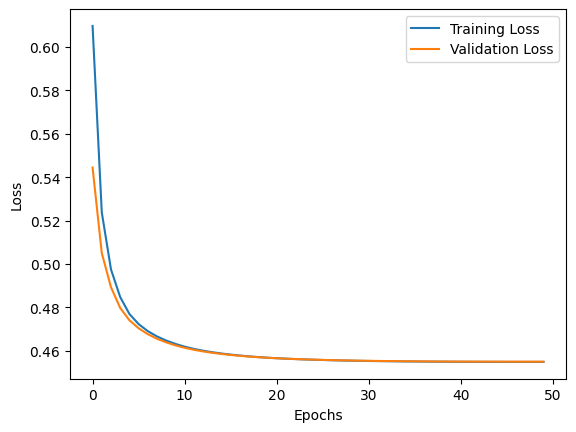

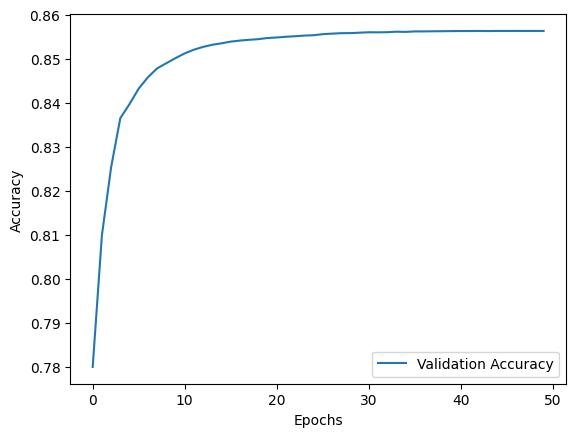

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter  # Import SummaryWriter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.iloc[:, 0].to_numpy(), dtype=torch.long).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val.iloc[:, 0].to_numpy(), dtype=torch.long).to(device)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Create a DataLoader for batching
batch_size = len(X_train) // 10  # Choose an appropriate batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Model definition
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(X_train.shape[1], 100),
            nn.LeakyReLU(),
            nn.Linear(100, 2),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)

mlp_model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.01)

# Add Cosine Annealing LR scheduler
num_epochs = 50
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

# Mixed-precision training
scaler = GradScaler()

# Set up TensorBoard
writer = SummaryWriter()

train_losses = []
val_losses = []
val_accuracies = []

print(f"Training model on {device}")

for epoch in tqdm(range(num_epochs), desc='Epochs'):
    mlp_model.train()
    total_loss = 0.0

    # Training loop
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()

        # Use mixed-precision training
        with autocast():
            outputs = mlp_model(batch_X)
            loss = criterion(outputs, batch_y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    # Update learning rate using scheduler
    scheduler.step()

    # Calculate average training loss
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Validation
    mlp_model.eval()
    with torch.no_grad():
        outputs = mlp_model(X_val_tensor)
        val_loss = criterion(outputs, y_val_tensor)
        predictions = torch.argmax(outputs, dim=1)
        val_accuracy = accuracy_score(y_val_tensor.cpu().numpy(), predictions.cpu().numpy())
    val_losses.append(val_loss.item())
    val_accuracies.append(val_accuracy)

    # Print and log results
    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {avg_loss:.4f}, Validation Loss: {val_loss.item():.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # Log to TensorBoard
    writer.add_scalar('Loss/Train', avg_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss.item(), epoch)
    writer.add_scalar('Accuracy/Validation', val_accuracy, epoch)

# Close the TensorBoard writer
writer.close()

# Plotting
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()


In [32]:
mlp_model.eval()
with torch.no_grad():
    outputs = mlp_model(X_val_tensor)
    val_loss = criterion(outputs, y_val_tensor)
    predictions = torch.argmax(outputs, dim=1)
    val_accuracy = accuracy_score(y_val_tensor.cpu().numpy(), predictions.cpu().numpy())

# Print and log results
print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {avg_loss:.4f}, Validation Loss: {val_loss.item():.4f}, Validation Accuracy: {val_accuracy:.4f}')

# Classification report and F1 score
linear_layer = mlp_model.network[-2]  # Access the linear layer before the sigmoid
target_names = [f'Class {i}' for i in range(linear_layer.out_features)]
classification_rep = classification_report(y_val_tensor.cpu().numpy(), predictions.cpu().numpy(), target_names=target_names)
f1 = f1_score(y_val_tensor.cpu().numpy(), predictions.cpu().numpy(), average='weighted')

print("2 Layers NN Classification Report:\n", classification_rep)
print(f'Weighted F1 Score: {f1:.4f}')


Epoch [50/50], Training Loss: 0.4538, Validation Loss: 0.4538, Validation Accuracy: 0.8575
2 Layers NN Classification Report:
               precision    recall  f1-score   support

     Class 0       0.86      0.89      0.87    960222
     Class 1       0.85      0.82      0.83    753811

    accuracy                           0.86   1714033
   macro avg       0.86      0.85      0.85   1714033
weighted avg       0.86      0.86      0.86   1714033

Weighted F1 Score: 0.8571


# Creating Test Data

In [9]:
print('Importing Testing Datasets')
test_series=pd.read_parquet(path="/kaggle/input/child-mind-institute-detect-sleep-states/test_series.parquet", engine='auto')
print('Dataset Imported...')

print('Removing the periods of Inactivity...')
test_series=inactive_periods(test_series)
print('______________________________________')

print('Adding Features...')
test_series=rollingstd(test_series)
test_series['sd_anglez_1']=pd.to_numeric(test_series['sd_anglez_1'])
test_series['sd_enmo_1']=pd.to_numeric(test_series['sd_enmo_1'])
test_series['m_anglez_2']=pd.to_numeric(test_series['m_anglez_2'])
test_series['m_enmo_2']=pd.to_numeric(test_series['m_enmo_2'])
print('Features added...')

print('Clustering the data based on enmo and anglez...')
test_series['cluster']=(clustering(test_series)+1)/4

X_test=test_series[['sd_anglez_1','sd_enmo_1','anglez','m_anglez_2','m_enmo_2','enmo','cluster']]

y_pred=gbc.predict(scale(X_test))
X_test=[]

Importing Testing Datasets
Dataset Imported...
______________________________________
Removing the periods of Inactivity...
shape before application:  (450, 5)
shape after application:  (322, 6)
shape after completion:  (322, 5)
removed 
______________________________________
Adding Features...
anglez rolling std 12
anglez rolling std 2
enmo rolling std 12
enmo rolling mean 24
anglez rolling mean 24
enmo rolling std 2
Nans in sd_emno_1:  33
enmo rolling mean 2
anglez rolling mean 2
Nans in sd_emno_1:  3
Nans after removal:  0
Features added...
______________________________________
Clustering the data based on enmo and anglez...
Added clusters...


AttributeError: 'StackingClassifier' object has no attribute 'estimators_'

In [ ]:
result_df=test_series[['series_id', 'step','timestamp']]
result_df['sleep']=y_pred
result_df['timestamp']=result_df[['timestamp']].progress_apply(lambda x: pd.to_datetime(x,utc=True))

In [ ]:
df=result_df.copy()
df.index=df['timestamp']
mean = df.groupby([df['series_id'], df.index.floor('30min')])['sleep'].mean()  # Calculating the mean of predictions over an interval of 30 mins. 
summary=pd.merge(result_df,mean,on=["timestamp","series_id"],how='left')  # merging the means into the original data based on timestamps and series ID.
summary=summary[summary['sleep_y'].isna()==False]  # removing the Nan's of prediction mean. That'll ensure that we have a row every 30 mins.
# Creating Event Column
summary['event']=np.nan
summary.loc[summary["sleep_y"]>0.5, "event"] = 'onset'  # the mean prediction will be 1 if predicted onset for 30 mins consecutive
summary.loc[summary["sleep_y"]<0.5, "event"] = 'wakeup' # the mean prediction will be 0 if predicted wakeup for 30 mins consecutive. Any duration in between will be considered disturbance as will be less tan 30 mins.
summary=summary[summary['event'].isna()==False] # Removing the rows with no event recorded. 
summary=summary.reset_index()
summary=summary.reset_index()
summary=summary.rename(columns={'level_0': 'row_id'})
summary.index=summary['row_id']
submission=summary[['series_id','step','event','sleep_y']]  # Creating Submission
submission['sleep_y'][submission['event']=='wakeup']=1-submission["sleep_y"]
submission = submission.rename(columns={'sleep_y': 'score'})  # Renaming a column
submission.to_csv('submission.csv')  # Saving the csv file


In [ ]:
submission.index=submission['series_id']
submission=submission.drop(columns='series_id')
submission.to_csv('submission.csv')
